# Embeddings in Language Models
**Goal:** Given a sequence of tokens $t_1$ ... $t_n$ how do we encode the position of each token into a $d$ dim vector

Desirable Properties
1. Obv have the ability to encode the "distance"
    * if distance(t1, t2) < distance (t4, t8)
    * relative_distance(t1, t2) == relative_distance(t6, t7) ie they are both 1 position apart
1. Each position should have a unique embedding
3. Idempotent.
4. Parameter Free (no weights) to reduce computational load. There are obv version that 'learn' the position embeddings. Currently we disucss "fixed" embeddings.

Binary Position Encoding Table:
Position  Low  Med  High  Vhigh
     P_0    0    0     0      0
     P_1    1    0     0      0
     P_2    0    1     0      0
     P_3    1    1     0      0
     P_4    0    0     1      0
     P_5    1    0     1      0
     P_6    0    1     1      0
     P_7    1    1     1      0
     P_8    0    0     0      1
     P_9    1    0     0      1
    P_10    0    1     0      1
    P_11    1    1     0      1
    P_12    0    0     1      1
    P_13    1    0     1      1
    P_14    0    1     1      1
    P_15    1    1     1      1


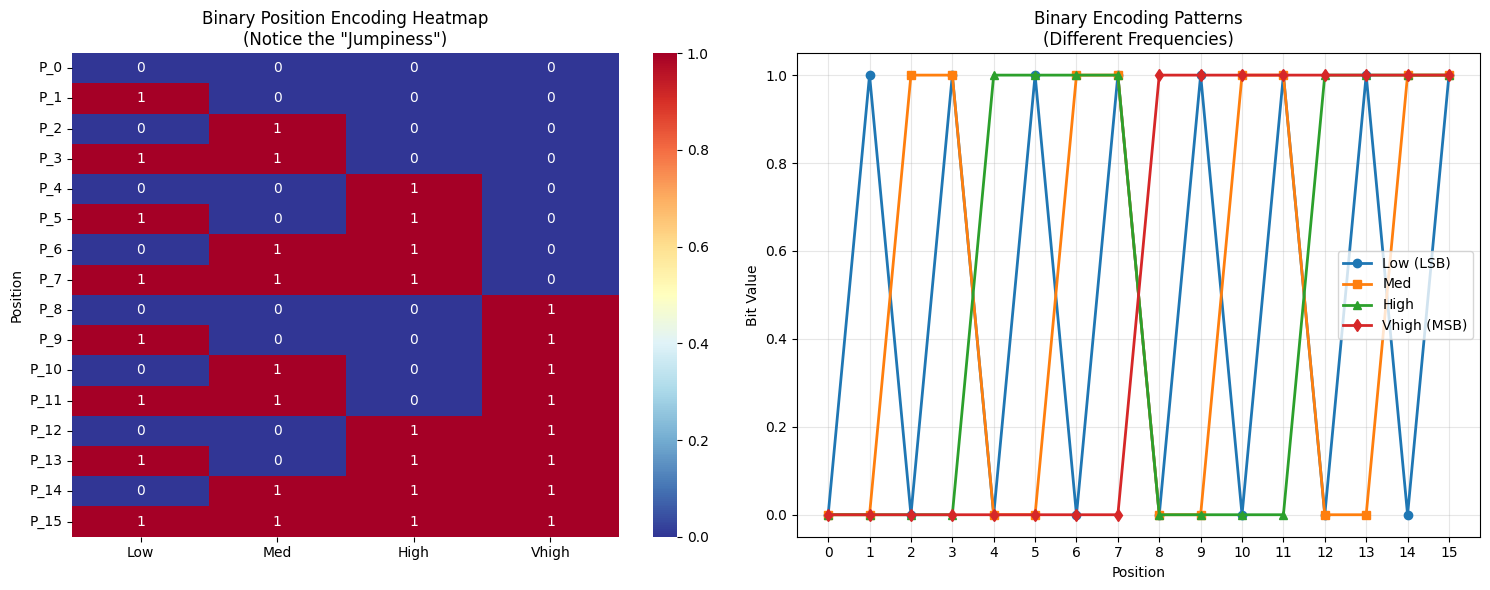

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create binary position encoding data
positions = list(range(16))
binary_data = []

for pos in positions:
    # Convert to 4-bit binary
    binary = format(pos, '04b')
    binary_data.append({
        'Position': f'P_{pos}',
        'Low': int(binary[3]),      # Least significant bit (rightmost)
        'Med': int(binary[2]),      
        'High': int(binary[1]),     
        'Vhigh': int(binary[0])     # Most significant bit (leftmost)
    })

# Create DataFrame
df = pd.DataFrame(binary_data)

# Print the DataFrame nicely
print("Binary Position Encoding Table:")
print("=" * 40)
print(df.to_string(index=False))

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Heatmap showing the "jumpiness"
binary_matrix = df[['Low', 'Med', 'High', 'Vhigh']].values
sns.heatmap(binary_matrix, 
            annot=True, 
            cmap='RdYlBu_r', 
            cbar=True,
            xticklabels=['Low', 'Med', 'High', 'Vhigh'],
            yticklabels=[f'P_{i}' for i in range(16)],
            ax=ax1)
ax1.set_title('Binary Position Encoding Heatmap\n(Notice the "Jumpiness")')
ax1.set_ylabel('Position')

# Plot 2: Line plot showing frequency patterns
ax2.plot(positions, df['Low'], 'o-', label='Low (LSB)', linewidth=2)
ax2.plot(positions, df['Med'], 's-', label='Med', linewidth=2)  
ax2.plot(positions, df['High'], '^-', label='High', linewidth=2)
ax2.plot(positions, df['Vhigh'], 'd-', label='Vhigh (MSB)', linewidth=2)
ax2.set_xlabel('Position')
ax2.set_ylabel('Bit Value')
ax2.set_title('Binary Encoding Patterns\n(Different Frequencies)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(positions)

plt.tight_layout()
plt.show()

**The Intuition behing using Relative Positions**

The ability to represent relative positions through linear transformations is crucial because **language patterns are inherently relative, not absolute**.

**Key insight:** Grammatical and semantic relationships depend on *relative distances* between words, not their absolute positions in a sentence.

**Examples:**
- "The cat is **not** happy" - "not" modifies "happy" whether they're at positions (5,6) or (15,16)
- Subject-verb-object relationships work the same at the start, middle, or end of sentences

**Without relative positioning:**
The model would need to separately learn:
- "not happy" at positions (3,4)
- "not happy" at positions (8,9)  
- "not happy" at positions (12,13)
- ...and so on for every possible absolute position

**With relative positioning:**
The model learns **one universal pattern** for "modifier + word" relationships that works everywhere in the sequence.

**Benefits:**
1. **Generalization** - Patterns learned in one part of a sequence transfer to other parts
2. **Efficiency** - Fewer parameters needed since relative patterns are reused
3. **Length flexibility** - Models can handle longer sequences than they were trained on
4. **Natural language alignment** - Matches how humans process language relationships

This is why sinusoidal encoding was revolutionary - it made transformers "position-aware" while preserving the relative, transferable patterns that make language understanding possible.

In [19]:
import torch 

max_seq = 64
hidden_size = 1024

In [20]:
pe = torch.zeros((max_seq, hidden_size))

In [21]:
positions = torch.arange(0, max_seq, step=1).unsqueeze(dim=1)

In [22]:
idx = torch.arange(0, hidden_size, 2)
idx
pe[:, 0::2] = torch.sin(positions * 5)
pe[:, 1::2] = torch.cos(positions * 5)
pe


tensor([[ 0.0000,  1.0000,  0.0000,  ...,  1.0000,  0.0000,  1.0000],
        [-0.9589,  0.2837, -0.9589,  ...,  0.2837, -0.9589,  0.2837],
        [-0.5440, -0.8391, -0.5440,  ..., -0.8391, -0.5440, -0.8391],
        ...,
        [-0.2624, -0.9650, -0.2624,  ..., -0.9650, -0.2624, -0.9650],
        [ 0.8509, -0.5253,  0.8509,  ..., -0.5253,  0.8509, -0.5253],
        [ 0.7451,  0.6669,  0.7451,  ...,  0.6669,  0.7451,  0.6669]])

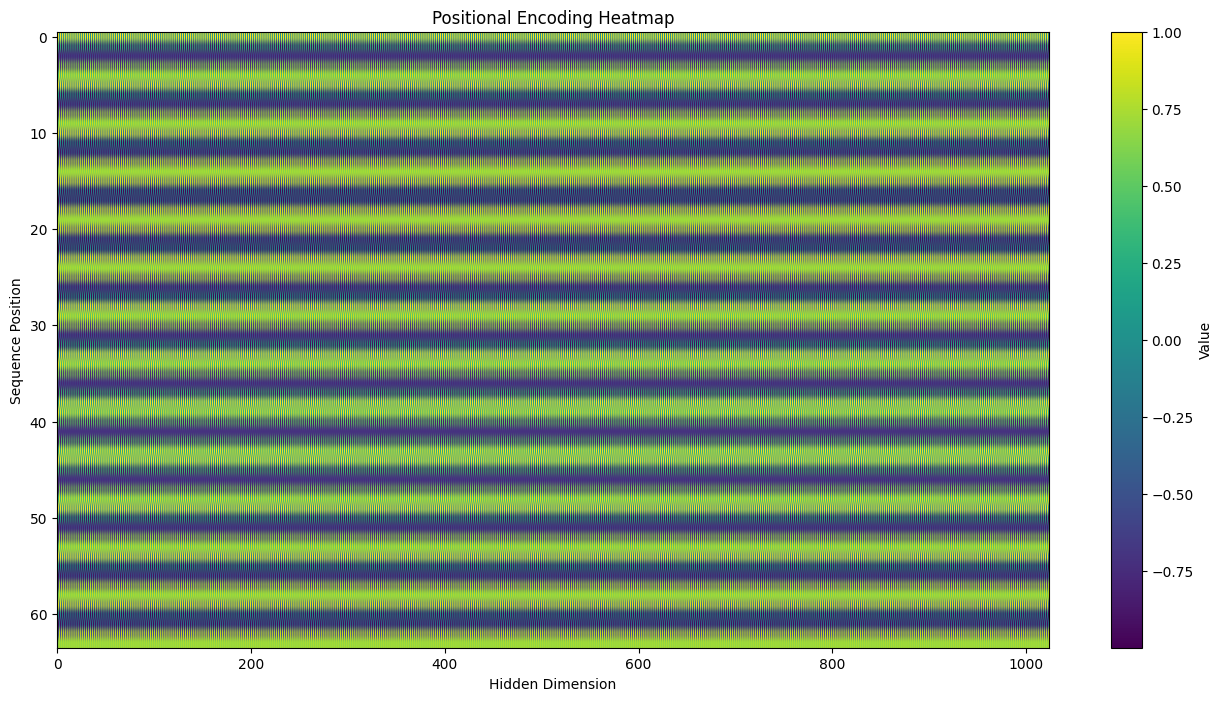

In [25]:
import matplotlib.pyplot as plt

# Method 1: Basic heatmap with imshow
plt.figure(figsize=(16, 8))
plt.imshow(pe.numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('Positional Encoding Heatmap')
plt.xlabel('Hidden Dimension')
plt.ylabel('Sequence Position')
plt.show()